## 1 - Data 

In [1]:
import pandas as pd
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from datetime import datetime
import nltk
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm
import yfinance as yf
import time
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler

In [2]:
comments_data = pd.read_csv("/Users/marco/Library/CloudStorage/OneDrive-ErasmusUniversityRotterdam/University - OD/EUR/MSc Thesis/Data/stocktwits_data.csv")
comments_data

,ticker,id,created_at,user,body
0,MMM,574948072,2024-05-31 22:07:52,TheClockworkGroup,"$MMM #NYSE | The markets are unpredictable, bu..."
1,MMM,574928917,2024-05-31 19:37:27,fishinNbanjo,"$MMM wow, that went to hell"
2,MMM,574915317,2024-05-31 18:13:34,RustyToo,$MMM Hear directly from the 3M scientist who w...
3,MMM,574908409,2024-05-31 17:30:20,LiveTradePro,$QQQ Setup confirmed All about follow through...
4,MMM,574908274,2024-05-31 17:29:31,DeepFknValue,@cajunman I was in $MMM preCovid and it just h...
...,...,...,...,...,...
1086042,NVDA,559107987,2024-01-25 00:13:30,Pianonymous,@dracorx What $NVDA bulls are feeling now is w...
1086043,NVDA,559107525,2024-01-25 00:09:20,CharlesXBrown,$LAES $NVDA Is it 12 or 15? Im good either way
1086044,NVDA,559107201,2024-01-25 00:06:21,SonGoku,Nothing is too oversold $TSLA \n\nNothing is t...
1086045,NVDA,559106977,2024-01-25 00:04:15,AthleticBeing,That’s how we trust our conviction and go agai...


In [3]:
comments_data = comments_data.dropna(subset=['created_at', 'ticker', 'body', 'user'])
print(comments_data.isnull().sum())  

ticker        0
id            0
created_at    0
user          0
body          0
dtype: int64


In [4]:
comments_data['created_at'] = pd.to_datetime(comments_data['created_at'])
comments_data

/var/folders/bz/jsngdqs55xxdjx6nm7z430l00000gn/T/ipykernel_1250/2117105917.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comments_data['created_at'] = pd.to_datetime(comments_data['created_at'])


,ticker,id,created_at,user,body
0,MMM,574948072,2024-05-31 22:07:52,TheClockworkGroup,"$MMM #NYSE | The markets are unpredictable, bu..."
1,MMM,574928917,2024-05-31 19:37:27,fishinNbanjo,"$MMM wow, that went to hell"
2,MMM,574915317,2024-05-31 18:13:34,RustyToo,$MMM Hear directly from the 3M scientist who w...
3,MMM,574908409,2024-05-31 17:30:20,LiveTradePro,$QQQ Setup confirmed All about follow through...
4,MMM,574908274,2024-05-31 17:29:31,DeepFknValue,@cajunman I was in $MMM preCovid and it just h...
...,...,...,...,...,...
1086042,NVDA,559107987,2024-01-25 00:13:30,Pianonymous,@dracorx What $NVDA bulls are feeling now is w...
1086043,NVDA,559107525,2024-01-25 00:09:20,CharlesXBrown,$LAES $NVDA Is it 12 or 15? Im good either way
1086044,NVDA,559107201,2024-01-25 00:06:21,SonGoku,Nothing is too oversold $TSLA \n\nNothing is t...
1086045,NVDA,559106977,2024-01-25 00:04:15,AthleticBeing,That’s how we trust our conviction and go agai...


### 1.2 Variables Definition

Together with sentiment scores, it's crucial to define other "assistance" variables that may improve the performance of this Stock-Twits factor. Common variabels in social-media studies are attention measures. The design of these attention measures is this study was inspired by the ones defined in [Cookson et al. (2023)](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=4241505), and then adapted to match Stocktwits attention measures. 

#### Attention Measures

To create an attention measure, we first need to extract the dates and remove the time of creation of the post, in order to pool together posts beloning to the same date.

Then the following variables are created:

* **M_vol** = number of messages per firm per day 
* **Avg_M_firm/d** = average daily message volume per ticker across the whole period
* **M_tot/d** = total messages per day, across al firms 
* **A_Cookson** = attention measure as defined in [Cookson et al. (2023)](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=4241505). 
* **A_rel** = relative attention measure, computed as the ticker daily message volume over the average daily message volume of that ticker across the whole time frame.

All the variables are then stored in the dataframe: *attention_measures*

In [5]:
comments_data['date'] = pd.to_datetime(comments_data['created_at'].dt.date)

start_date = comments_data['date'].min()
end_date = comments_data['date'].max()
full_date_range = pd.date_range(start=start_date, end=end_date)

all_tickers = comments_data['ticker'].unique()

complete_index = pd.MultiIndex.from_product([all_tickers, full_date_range], names=['ticker', 'date'])
attention_measures = pd.DataFrame(index=complete_index).reset_index()
attention_measures['M_vol'] = 0

/var/folders/bz/jsngdqs55xxdjx6nm7z430l00000gn/T/ipykernel_1250/1979002454.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comments_data['date'] = pd.to_datetime(comments_data['created_at'].dt.date)


In [6]:
message_volume = comments_data.groupby(['ticker', 'date']).size().reset_index(name='M_vol')
attention_measures = attention_measures.merge(message_volume, on=['ticker', 'date'], how='left')
attention_measures['M_vol'] = attention_measures['M_vol_y'].fillna(0).astype(int)
attention_measures.drop(columns=['M_vol_x', 'M_vol_y'], inplace=True)

In [7]:
tot_messages = comments_data.groupby('date').size().reset_index(name='M_tot/d')
attention_measures = attention_measures.merge(tot_messages, on='date')

attention_measures['A_Cookson'] = np.where(
    attention_measures['M_vol'] == 0,
    np.nan,  
    attention_measures['M_vol'] / attention_measures['M_tot/d']
)

In [8]:
message_volume = attention_measures[['M_vol', 'ticker']]
average_daily_message_volume = message_volume.groupby('ticker')['M_vol'].mean().reset_index(name='Avg_M_firm/d')
attention_measures = attention_measures.merge(average_daily_message_volume, on='ticker')
attention_measures['A_rel'] = attention_measures['M_vol'] / attention_measures['Avg_M_firm/d']

Given the formulation of the A_Cookson variable ($\frac{Messages_{i,t}}{Messages_t}$), a zero is inserted when there are no messages for firm i on day t in order to avoid missing values.

In [9]:
attention_measures['A_Cookson'] = attention_measures['A_Cookson'].fillna(0)
attention_measures

,ticker,date,M_vol,M_tot/d,A_Cookson,Avg_M_firm/d,A_rel
0,MMM,2024-01-01,4,707,0.005658,16.782895,0.238338
1,MMM,2024-01-02,9,5731,0.001570,16.782895,0.536260
2,MMM,2024-01-03,10,5542,0.001804,16.782895,0.595845
3,MMM,2024-01-04,6,6104,0.000983,16.782895,0.357507
4,MMM,2024-01-05,3,5824,0.000515,16.782895,0.178753
...,...,...,...,...,...,...,...
76299,NVDA,2024-05-27,379,1311,0.289092,1451.098684,0.261181
76300,NVDA,2024-05-28,4915,10814,0.454503,1451.098684,3.387089
76301,NVDA,2024-05-29,4292,11793,0.363945,1451.098684,2.957759
76302,NVDA,2024-05-30,3357,12780,0.262676,1451.098684,2.313420


The attention measures created can be vizualized in a chart like the following:

/var/folders/bz/jsngdqs55xxdjx6nm7z430l00000gn/T/ipykernel_1250/3185434913.py:7: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  line1, = ax1.plot(ticker_data.index, ticker_data['A_Cookson'], 'bo', label='Attention', color='royalblue')


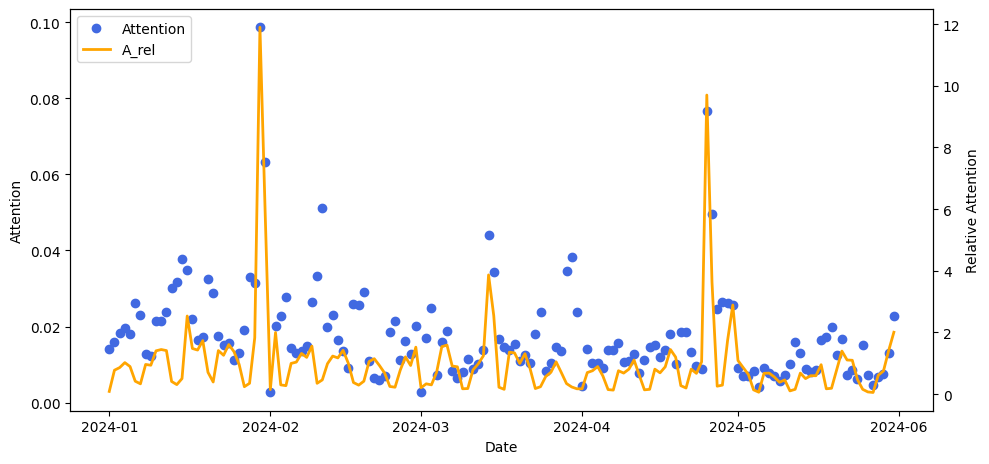

In [41]:
ticker = 'MSFT'

ticker_data = attention_measures[attention_measures['ticker'] == ticker]
ticker_data.set_index('date', inplace=True)
fig, ax1 = plt.subplots(figsize=(10, 5))

line1, = ax1.plot(ticker_data.index, ticker_data['A_Cookson'], 'bo', label='Attention', color='royalblue')
ax1.set_xlabel('Date')
ax1.set_ylabel('Attention')
ax1.tick_params(axis='y', colors='black')

ax2 = ax1.twinx()
line2, = ax2.plot(ticker_data.index, ticker_data['A_rel'], label='Relative Attention', color='orange', linestyle='-', linewidth=2)
ax2.set_ylabel('Relative Attention')
ax2.tick_params(axis='y', colors='black')

fig.legend([line1, line2], ['Attention', 'A_rel'], loc="upper left", bbox_to_anchor=(0,1), bbox_transform=ax1.transAxes)
fig.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

### 1.3 - VADER Sentiment Analysis 

In [11]:
nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/marco/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [12]:
test = comments_data['body'][5]
test

'$MMM 3M is a corrupt and unethical company. Careful.'

In [13]:
sia.polarity_scores(test)

{'neg': 0.303, 'neu': 0.55, 'pos': 0.147, 'compound': -0.4019}

In [14]:
res = {}
for i, row in tqdm(comments_data.iterrows(), total=len(comments_data)):
    text = row['body']
    com_id = row['id']
    res[com_id] = sia.polarity_scores(text)
#takes approx. 2 min to complete

  0%|          | 0/1084175 [00:00<?, ?it/s]

In [15]:
vader = pd.DataFrame(res).T
vader = vader.reset_index().rename(columns={'index': 'id'})
vader = vader.merge(comments_data, how='left')

In [16]:
vader

,id,neg,neu,pos,compound,ticker,created_at,user,body,date
0,574948072,0.000,0.796,0.204,0.8881,MMM,2024-05-31 22:07:52,TheClockworkGroup,"$MMM #NYSE | The markets are unpredictable, bu...",2024-05-31
1,574928917,0.371,0.323,0.306,-0.2023,MMM,2024-05-31 19:37:27,fishinNbanjo,"$MMM wow, that went to hell",2024-05-31
2,574915317,0.038,0.962,0.000,-0.4404,MMM,2024-05-31 18:13:34,RustyToo,$MMM Hear directly from the 3M scientist who w...,2024-05-31
3,574908409,0.000,1.000,0.000,0.0000,MMM,2024-05-31 17:30:20,LiveTradePro,$QQQ Setup confirmed All about follow through...,2024-05-31
4,574908274,0.000,1.000,0.000,0.0000,MMM,2024-05-31 17:29:31,DeepFknValue,@cajunman I was in $MMM preCovid and it just h...,2024-05-31
...,...,...,...,...,...,...,...,...,...,...
1084170,559107987,0.000,0.824,0.176,0.2500,NVDA,2024-01-25 00:13:30,Pianonymous,@dracorx What $NVDA bulls are feeling now is w...,2024-01-25
1084171,559107525,0.000,0.775,0.225,0.4404,NVDA,2024-01-25 00:09:20,CharlesXBrown,$LAES $NVDA Is it 12 or 15? Im good either way,2024-01-25
1084172,559107201,0.000,1.000,0.000,0.0000,NVDA,2024-01-25 00:06:21,SonGoku,Nothing is too oversold $TSLA \n\nNothing is t...,2024-01-25
1084173,559106977,0.107,0.737,0.156,0.5080,NVDA,2024-01-25 00:04:15,AthleticBeing,That’s how we trust our conviction and go agai...,2024-01-25


### 1.4 - RoBERTa Sentiment Analysis

In [17]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

In [18]:
chunk_size = len(comments_data) // 10  # Split into 10 chunks
chunks = [comments_data[i:i + chunk_size] for i in range(0, len(comments_data), chunk_size)]

In [19]:
MODEL = f'cardiffnlp/twitter-roberta-base-sentiment'
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

In [20]:
# Run for Roberta Model
encoded_text = tokenizer(test, return_tensors='pt')
output = model(**encoded_text)
scores = output[0][0].detach().numpy()
scores = softmax(scores)
scores_dict = {
    'roberta_neg': scores[0],
    'roberta_neu': scores[1],
    'roberta_pos': scores[2]
}

print(scores_dict)

{'roberta_neg': 0.9412956, 'roberta_neu': 0.054977484, 'roberta_pos': 0.0037268766}


In [21]:
def polarity_scores_roberta(test):
    encoded_text = tokenizer(test, return_tensors='pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'roberta_neg': scores[0],
        'roberta_neu': scores[1],
        'roberta_pos': scores[2]
    }
    return scores_dict

In [22]:
def process_chunk(chunk, chunk_number):
    res = {}
    for i, row in tqdm(chunk.iterrows(), total=len(chunk)):
        try:
            text = row['body']
            com_id = row['id']
            roberta_result = polarity_scores_roberta(text)
            res[com_id] = roberta_result
        except RuntimeError:
            print(f'Broke for id {com_id}')

    result_df = pd.DataFrame.from_dict(res, orient='index')
    result_df.reset_index(inplace=True)
    result_df.rename(columns={'index': 'id'}, inplace=True)

    result_df.to_csv(f'sentiment_results_chunk_{chunk_number}.csv', index=False)
    print(f'Chunk {chunk_number} processed and saved.')

In [23]:
chunk_number = 10  # Specify which chunk to process
process_chunk(chunks[chunk_number], chunk_number)
# Takes 4hrs per chunk -> approximately 40hrs total.

  0%|          | 0/5 [00:00<?, ?it/s]

Chunk 10 processed and saved.


During the roBERTa sentiment analysis, some comments were not successfully processed. Given the low number (240 comments), those were excluded from the dataset.

Now the sentiment analysys results obtained from nltk and roBerta are combined in a sigle data frame to then create variables and start modeling:

In [24]:
l = list(range(0, 11))

data_frames = {}

for i in l:
    data_frames[f'chunk_{i}'] = pd.read_csv(f'/Users/marco/Library/CloudStorage/OneDrive-ErasmusUniversityRotterdam/University - OD/EUR/MSc Thesis/Data/sentiment_results_chunk_{i}.csv')

roberta_sentiment = pd.concat(data_frames.values(), ignore_index=True)

In [25]:
sentiment_data = roberta_sentiment.merge(vader, how='left')
sentiment_data

,id,roberta_neg,roberta_neu,roberta_pos,neg,neu,pos,compound,ticker,created_at,user,body,date
0,574948072,0.003141,0.092694,0.904165,0.000,0.796,0.204,0.8881,MMM,2024-05-31 22:07:52,TheClockworkGroup,"$MMM #NYSE | The markets are unpredictable, bu...",2024-05-31
1,574928917,0.941562,0.051395,0.007044,0.371,0.323,0.306,-0.2023,MMM,2024-05-31 19:37:27,fishinNbanjo,"$MMM wow, that went to hell",2024-05-31
2,574915317,0.704376,0.267132,0.028492,0.038,0.962,0.000,-0.4404,MMM,2024-05-31 18:13:34,RustyToo,$MMM Hear directly from the 3M scientist who w...,2024-05-31
3,574908409,0.003834,0.478237,0.517929,0.000,1.000,0.000,0.0000,MMM,2024-05-31 17:30:20,LiveTradePro,$QQQ Setup confirmed All about follow through...,2024-05-31
4,574908274,0.043001,0.863248,0.093751,0.000,1.000,0.000,0.0000,MMM,2024-05-31 17:29:31,DeepFknValue,@cajunman I was in $MMM preCovid and it just h...,2024-05-31
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1083930,559107987,0.039442,0.748142,0.212416,0.000,0.824,0.176,0.2500,NVDA,2024-01-25 00:13:30,Pianonymous,@dracorx What $NVDA bulls are feeling now is w...,2024-01-25
1083931,559107525,0.006342,0.156151,0.837507,0.000,0.775,0.225,0.4404,NVDA,2024-01-25 00:09:20,CharlesXBrown,$LAES $NVDA Is it 12 or 15? Im good either way,2024-01-25
1083932,559107201,0.384766,0.536835,0.078398,0.000,1.000,0.000,0.0000,NVDA,2024-01-25 00:06:21,SonGoku,Nothing is too oversold $TSLA \n\nNothing is t...,2024-01-25
1083933,559106977,0.005367,0.115389,0.879243,0.107,0.737,0.156,0.5080,NVDA,2024-01-25 00:04:15,AthleticBeing,That’s how we trust our conviction and go agai...,2024-01-25


#### Sentiment Measures

An overall sentiment meaures is computed as:

$positive\ score_{i,t} + 0 \times neutral\ score_{i,t} - negative\ score_{i,t}$ 

which simplifies to:

\begin{equation}
     positive\ score_{i,t} - negative\ score_{i,t}
\end{equation}

for both vader and roberta values, in order to have a comprehensive sentiment measures that will facilitate the sorting process in the portfolio strategy.

In [26]:
sentiment_data['roberta_S'] = sentiment_data['roberta_pos'] - sentiment_data['roberta_neg']
sentiment_data['vader_S'] = sentiment_data['pos'] - sentiment_data['neg']

In [27]:
sentiment_data

,id,roberta_neg,roberta_neu,roberta_pos,neg,neu,pos,compound,ticker,created_at,user,body,date,roberta_S,vader_S
0,574948072,0.003141,0.092694,0.904165,0.000,0.796,0.204,0.8881,MMM,2024-05-31 22:07:52,TheClockworkGroup,"$MMM #NYSE | The markets are unpredictable, bu...",2024-05-31,0.901024,0.204
1,574928917,0.941562,0.051395,0.007044,0.371,0.323,0.306,-0.2023,MMM,2024-05-31 19:37:27,fishinNbanjo,"$MMM wow, that went to hell",2024-05-31,-0.934518,-0.065
2,574915317,0.704376,0.267132,0.028492,0.038,0.962,0.000,-0.4404,MMM,2024-05-31 18:13:34,RustyToo,$MMM Hear directly from the 3M scientist who w...,2024-05-31,-0.675884,-0.038
3,574908409,0.003834,0.478237,0.517929,0.000,1.000,0.000,0.0000,MMM,2024-05-31 17:30:20,LiveTradePro,$QQQ Setup confirmed All about follow through...,2024-05-31,0.514095,0.000
4,574908274,0.043001,0.863248,0.093751,0.000,1.000,0.000,0.0000,MMM,2024-05-31 17:29:31,DeepFknValue,@cajunman I was in $MMM preCovid and it just h...,2024-05-31,0.050750,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1083930,559107987,0.039442,0.748142,0.212416,0.000,0.824,0.176,0.2500,NVDA,2024-01-25 00:13:30,Pianonymous,@dracorx What $NVDA bulls are feeling now is w...,2024-01-25,0.172975,0.176
1083931,559107525,0.006342,0.156151,0.837507,0.000,0.775,0.225,0.4404,NVDA,2024-01-25 00:09:20,CharlesXBrown,$LAES $NVDA Is it 12 or 15? Im good either way,2024-01-25,0.831164,0.225
1083932,559107201,0.384766,0.536835,0.078398,0.000,1.000,0.000,0.0000,NVDA,2024-01-25 00:06:21,SonGoku,Nothing is too oversold $TSLA \n\nNothing is t...,2024-01-25,-0.306368,0.000
1083933,559106977,0.005367,0.115389,0.879243,0.107,0.737,0.156,0.5080,NVDA,2024-01-25 00:04:15,AthleticBeing,That’s how we trust our conviction and go agai...,2024-01-25,0.873876,0.049


In [28]:
to_drop = ['id', 'user', 'body', 'created_at', 'ticker', 'date']
columns = [i for i in list(sentiment_data.columns) if i not in to_drop]

daily_sentiment = sentiment_data.groupby(['ticker', 'date'])[columns].mean().reset_index()
daily_sentiment

,ticker,date,roberta_neg,roberta_neu,roberta_pos,neg,neu,pos,compound,roberta_S,vader_S
0,A,2024-01-01,0.019773,0.562884,0.417344,0.0000,0.7810,0.2190,0.63690,0.397571,0.2190
1,A,2024-01-04,0.269511,0.553767,0.176721,0.0000,1.0000,0.0000,0.00000,-0.092790,0.0000
2,A,2024-01-05,0.281703,0.678933,0.039364,0.0540,0.8804,0.0656,0.09600,-0.242340,0.0116
3,A,2024-01-06,0.025090,0.906964,0.067947,0.0000,1.0000,0.0000,0.00000,0.042857,0.0000
4,A,2024-01-07,0.015686,0.800739,0.183575,0.0000,0.7920,0.2080,0.63690,0.167889,0.2080
...,...,...,...,...,...,...,...,...,...,...,...
42274,ZTS,2024-05-24,0.050144,0.323142,0.626715,0.0305,0.8040,0.1655,0.45435,0.576571,0.1350
42275,ZTS,2024-05-25,0.284887,0.641280,0.073833,0.0000,0.9240,0.0760,0.31820,-0.211054,0.0760
42276,ZTS,2024-05-28,0.138578,0.751024,0.110398,0.0000,1.0000,0.0000,0.00000,-0.028180,0.0000
42277,ZTS,2024-05-29,0.080666,0.726350,0.192984,0.0000,0.9275,0.0725,0.14800,0.112318,0.0725


#### Social Media Dataset - Variables

In [29]:
social_media_data = pd.merge(attention_measures, daily_sentiment, on=['ticker', 'date'], how='left')

**Note:** 

There are a few important considerations regarding the dataframes and time spans used. From January 1st to May 31st, there are 153 days, which, when multiplied by the 502 tickers, totals 76,304 observations in the attention measures dataset. However, not all companies receive comments every day—some have zero comments on certain days—resulting in a smaller daily sentiment dataset with 42,279 observations. This discrepancy is due to the aforementioned reason. Additionally, the next section references 51,876 observations because only 106 of the 153 days are trading days with available stock market and returns data.

### 1.5 - Importing Financial Data

Note that *GE Vervnova Inc* (GEV) and *Solventum Corp* (SOLV) have specific situations:

* GEV spineed-off from GE in April, meaning that it's a new stock with no price data until April.
* SOLV IPOd in April

There is no data covering the full time period for these two companies, but given that the twits match their price data, they will still be included in the analysis, while taking into account that there is only one month of data available.

In [30]:
tickers = list(comments_data['ticker'].unique())
tickers.remove('BRK.B')
tickers.remove('BF.B')

start_date = '2023-12-28'
end_date = '2024-06-01'

def get_data(ticker_subset):
    prices = yf.download(ticker_subset, start=start_date, end=end_date)
    adj_close = prices['Adj Close']
    returns = adj_close.pct_change()
    returns_long = returns.reset_index().melt(id_vars='Date', var_name='ticker', value_name='ret')
    return returns_long

rets = get_data(tickers)
rets = rets.dropna()
rets.rename(columns={'Date': 'date'}, inplace=True)

[*********************100%%**********************]  500 of 500 completed


### 1.6 Fama-French Data

Fama-French factor data is necessary in this reasearch mainly to evaluate 3- and 5-factor alpha when operating with portfolio sorts. In that way it is possible to evaluate the risk-adjusted returns of the StockTwits factor. However, they are also necessary to compute excess retursn, as the FF-dataframe also includes data for the risk-free rate *$r_f$*. 

*The data was downloaded from the [Fama-French data library](https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/data_library.html)*.

In [31]:
FF_data = pd.read_csv("/Users/marco/Library/CloudStorage/OneDrive-ErasmusUniversityRotterdam/University - OD/EUR/MSc Thesis/Data/F&F_data.csv", header=2)
FF_data.rename(columns={'Unnamed: 0':'date'}, inplace=True)
FF_data['date'] = pd.to_datetime(FF_data['date'], format='%Y%m%d')
FF_data = FF_data[(FF_data['date'] >= '2023-12-29') & (FF_data['date'] <= '2024-05-31')]

to_divide = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']
for i in to_divide:
    FF_data[i] = FF_data[i]/100
FF_data

,date,Mkt-RF,SMB,HML,RMW,CMA,RF
15228,2023-12-29,-0.0043,-0.0113,-0.0037,0.0068,-0.0007,0.021
15229,2024-01-02,-0.0070,-0.0025,0.0078,0.0070,0.0064,0.022
15230,2024-01-03,-0.0101,-0.0194,-0.0011,0.0033,-0.0018,0.022
15231,2024-01-04,-0.0033,0.0024,0.0009,-0.0041,0.0024,0.022
15232,2024-01-05,0.0015,-0.0059,0.0064,0.0011,-0.0015,0.022
...,...,...,...,...,...,...,...
15329,2024-05-24,0.0072,0.0017,0.0016,0.0031,-0.0039,0.020
15330,2024-05-28,-0.0004,0.0010,-0.0089,0.0005,-0.0112,0.020
15331,2024-05-29,-0.0077,-0.0039,-0.0062,0.0048,-0.0002,0.020
15332,2024-05-30,-0.0053,0.0136,0.0099,0.0034,0.0107,0.020


In [32]:
research_data = pd.merge(FF_data, social_media_data, on='date', how='left')
research_data = pd.merge(research_data, rets, on=['date', 'ticker'], how='left')
research_data

,date,Mkt-RF,SMB,HML,RMW,CMA,RF,ticker,M_vol,M_tot/d,...,roberta_neg,roberta_neu,roberta_pos,neg,neu,pos,compound,roberta_S,vader_S,ret
0,2023-12-29,-0.0043,-0.0113,-0.0037,0.0068,-0.0007,0.021,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2024-01-02,-0.0070,-0.0025,0.0078,0.0070,0.0064,0.022,MMM,9.0,5731.0,...,0.081047,0.669640,0.249313,0.053222,0.800111,0.146667,0.155311,0.168266,0.093444,0.006220
2,2024-01-02,-0.0070,-0.0025,0.0078,0.0070,0.0064,0.022,AOS,2.0,5731.0,...,0.374486,0.572005,0.053510,0.191500,0.808500,0.000000,-0.238350,-0.320976,-0.191500,-0.012130
3,2024-01-02,-0.0070,-0.0025,0.0078,0.0070,0.0064,0.022,ABT,4.0,5731.0,...,0.156287,0.647608,0.196105,0.000000,0.948000,0.052000,0.159225,0.039818,0.052000,-0.001999
4,2024-01-02,-0.0070,-0.0025,0.0078,0.0070,0.0064,0.022,ABBV,22.0,5731.0,...,0.056310,0.704331,0.239359,0.006227,0.906909,0.086818,0.153368,0.183050,0.080591,0.031296
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52706,2024-05-31,0.0068,-0.0003,0.0078,0.0091,0.0080,0.020,MSFT,236.0,10406.0,...,0.266645,0.501310,0.232045,0.092458,0.813492,0.094055,0.028573,-0.034601,0.001597,0.001109
52707,2024-05-31,0.0068,-0.0003,0.0078,0.0091,0.0080,0.020,TSLA,1072.0,10406.0,...,0.274290,0.501777,0.223934,0.073376,0.841557,0.085062,0.026171,-0.050356,0.011686,-0.003971
52708,2024-05-31,0.0068,-0.0003,0.0078,0.0091,0.0080,0.020,AMZN,483.0,10406.0,...,0.313564,0.478393,0.208043,0.097880,0.798602,0.103520,0.015593,-0.105522,0.005640,-0.016061
52709,2024-05-31,0.0068,-0.0003,0.0078,0.0091,0.0080,0.020,GOOG,15.0,10406.0,...,0.242113,0.458476,0.299411,0.066533,0.852200,0.081267,0.104940,0.057298,0.014733,0.002305


### 1.7 Final Data Preprocessing

For this reasearch, only trading days will be taken into account due to the fact that return data is not available for non-trading days. This will lead to the exclusion of sentiment and attention measures derived from non-trading days, and to the simplifying assumptions that sentiment for fridays affects the returns on mondays for instance. 

In [33]:
research_data = research_data.dropna(subset='ret')
research_data

,date,Mkt-RF,SMB,HML,RMW,CMA,RF,ticker,M_vol,M_tot/d,...,roberta_neg,roberta_neu,roberta_pos,neg,neu,pos,compound,roberta_S,vader_S,ret
1,2024-01-02,-0.0070,-0.0025,0.0078,0.0070,0.0064,0.022,MMM,9.0,5731.0,...,0.081047,0.669640,0.249313,0.053222,0.800111,0.146667,0.155311,0.168266,0.093444,0.006220
2,2024-01-02,-0.0070,-0.0025,0.0078,0.0070,0.0064,0.022,AOS,2.0,5731.0,...,0.374486,0.572005,0.053510,0.191500,0.808500,0.000000,-0.238350,-0.320976,-0.191500,-0.012130
3,2024-01-02,-0.0070,-0.0025,0.0078,0.0070,0.0064,0.022,ABT,4.0,5731.0,...,0.156287,0.647608,0.196105,0.000000,0.948000,0.052000,0.159225,0.039818,0.052000,-0.001999
4,2024-01-02,-0.0070,-0.0025,0.0078,0.0070,0.0064,0.022,ABBV,22.0,5731.0,...,0.056310,0.704331,0.239359,0.006227,0.906909,0.086818,0.153368,0.183050,0.080591,0.031296
5,2024-01-02,-0.0070,-0.0025,0.0078,0.0070,0.0064,0.022,ACN,1.0,5731.0,...,0.004133,0.152763,0.843104,0.000000,1.000000,0.000000,0.000000,0.838971,0.000000,-0.011370
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52706,2024-05-31,0.0068,-0.0003,0.0078,0.0091,0.0080,0.020,MSFT,236.0,10406.0,...,0.266645,0.501310,0.232045,0.092458,0.813492,0.094055,0.028573,-0.034601,0.001597,0.001109
52707,2024-05-31,0.0068,-0.0003,0.0078,0.0091,0.0080,0.020,TSLA,1072.0,10406.0,...,0.274290,0.501777,0.223934,0.073376,0.841557,0.085062,0.026171,-0.050356,0.011686,-0.003971
52708,2024-05-31,0.0068,-0.0003,0.0078,0.0091,0.0080,0.020,AMZN,483.0,10406.0,...,0.313564,0.478393,0.208043,0.097880,0.798602,0.103520,0.015593,-0.105522,0.005640,-0.016061
52709,2024-05-31,0.0068,-0.0003,0.0078,0.0091,0.0080,0.020,GOOG,15.0,10406.0,...,0.242113,0.458476,0.299411,0.066533,0.852200,0.081267,0.104940,0.057298,0.014733,0.002305


Abnormal Returns:

In [34]:
research_data['Ab_ret'] = research_data['ret']-research_data['Mkt-RF']

/var/folders/bz/jsngdqs55xxdjx6nm7z430l00000gn/T/ipykernel_1250/837892115.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  research_data['Ab_ret'] = research_data['ret']-research_data['Mkt-RF']


In [35]:
research_data = research_data.sort_values(by=['ticker', 'date'])
research_data['Ab_ret_nd'] = research_data.groupby('ticker')['Ab_ret'].shift(-1)
research_data = research_data.dropna(subset=['Ab_ret_nd'])
research_data

,date,Mkt-RF,SMB,HML,RMW,CMA,RF,ticker,M_vol,M_tot/d,...,roberta_pos,neg,neu,pos,compound,roberta_S,vader_S,ret,Ab_ret,Ab_ret_nd
9,2024-01-02,-0.0070,-0.0025,0.0078,0.0070,0.0064,0.022,A,0.0,5731.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.002014,0.004986,-0.044603
511,2024-01-03,-0.0101,-0.0194,-0.0011,0.0033,-0.0018,0.022,A,0.0,5542.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.054703,-0.044603,0.002080
1013,2024-01-04,-0.0033,0.0024,0.0009,-0.0041,0.0024,0.022,A,1.0,6104.0,...,0.176721,0.0000,1.0000,0.0000,0.00000,-0.092790,0.0000,-0.001220,0.002080,-0.004859
1515,2024-01-05,0.0015,-0.0059,0.0064,0.0011,-0.0015,0.022,A,5.0,5824.0,...,0.039364,0.0540,0.8804,0.0656,0.09600,-0.242340,0.0116,-0.003359,-0.004859,0.006700
2017,2024-01-08,0.0149,0.0053,-0.0127,-0.0098,-0.0047,0.022,A,0.0,8911.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.021600,0.006700,-0.018143
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50184,2024-05-23,-0.0085,-0.0066,-0.0065,0.0134,-0.0065,0.020,ZTS,2.0,14906.0,...,0.134655,0.0000,1.0000,0.0000,0.00000,0.076873,0.0000,-0.006684,0.001816,-0.012057
50686,2024-05-24,0.0072,0.0017,0.0016,0.0031,-0.0039,0.020,ZTS,2.0,8798.0,...,0.626715,0.0305,0.8040,0.1655,0.45435,0.576571,0.1350,-0.004857,-0.012057,0.007632
51188,2024-05-28,-0.0004,0.0010,-0.0089,0.0005,-0.0112,0.020,ZTS,1.0,10814.0,...,0.110398,0.0000,1.0000,0.0000,0.00000,-0.028180,0.0000,0.007232,0.007632,0.004781
51690,2024-05-29,-0.0077,-0.0039,-0.0062,0.0048,-0.0002,0.020,ZTS,2.0,11793.0,...,0.192984,0.0000,0.9275,0.0725,0.14800,0.112318,0.0725,-0.002919,0.004781,-0.002663


We are going to work with excess returns, which will be computed by subtracting the risk-free rate RF from the ret column:

In [36]:
research_data['ret'] = research_data['ret']-research_data['RF']
research_data.rename(columns={'ret':'exc_ret'}, inplace=True)
research_data

,date,Mkt-RF,SMB,HML,RMW,CMA,RF,ticker,M_vol,M_tot/d,...,roberta_pos,neg,neu,pos,compound,roberta_S,vader_S,exc_ret,Ab_ret,Ab_ret_nd
9,2024-01-02,-0.0070,-0.0025,0.0078,0.0070,0.0064,0.022,A,0.0,5731.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.024014,0.004986,-0.044603
511,2024-01-03,-0.0101,-0.0194,-0.0011,0.0033,-0.0018,0.022,A,0.0,5542.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.076703,-0.044603,0.002080
1013,2024-01-04,-0.0033,0.0024,0.0009,-0.0041,0.0024,0.022,A,1.0,6104.0,...,0.176721,0.0000,1.0000,0.0000,0.00000,-0.092790,0.0000,-0.023220,0.002080,-0.004859
1515,2024-01-05,0.0015,-0.0059,0.0064,0.0011,-0.0015,0.022,A,5.0,5824.0,...,0.039364,0.0540,0.8804,0.0656,0.09600,-0.242340,0.0116,-0.025359,-0.004859,0.006700
2017,2024-01-08,0.0149,0.0053,-0.0127,-0.0098,-0.0047,0.022,A,0.0,8911.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.000400,0.006700,-0.018143
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50184,2024-05-23,-0.0085,-0.0066,-0.0065,0.0134,-0.0065,0.020,ZTS,2.0,14906.0,...,0.134655,0.0000,1.0000,0.0000,0.00000,0.076873,0.0000,-0.026684,0.001816,-0.012057
50686,2024-05-24,0.0072,0.0017,0.0016,0.0031,-0.0039,0.020,ZTS,2.0,8798.0,...,0.626715,0.0305,0.8040,0.1655,0.45435,0.576571,0.1350,-0.024857,-0.012057,0.007632
51188,2024-05-28,-0.0004,0.0010,-0.0089,0.0005,-0.0112,0.020,ZTS,1.0,10814.0,...,0.110398,0.0000,1.0000,0.0000,0.00000,-0.028180,0.0000,-0.012768,0.007632,0.004781
51690,2024-05-29,-0.0077,-0.0039,-0.0062,0.0048,-0.0002,0.020,ZTS,2.0,11793.0,...,0.192984,0.0000,0.9275,0.0725,0.14800,0.112318,0.0725,-0.022919,0.004781,-0.002663


Now, next-day returns will be computed, simply by shifting the *exc_ret* column up by one day. *Note that this procedure entails the loss of the last observation.*

In [37]:
research_data = research_data.sort_values(by=['ticker', 'date'])
research_data['exc_ret_nd'] = research_data.groupby('ticker')['exc_ret'].shift(-1)
research_data = research_data.dropna(subset=['exc_ret_nd'])
research_data

,date,Mkt-RF,SMB,HML,RMW,CMA,RF,ticker,M_vol,M_tot/d,...,neg,neu,pos,compound,roberta_S,vader_S,exc_ret,Ab_ret,Ab_ret_nd,exc_ret_nd
9,2024-01-02,-0.0070,-0.0025,0.0078,0.0070,0.0064,0.022,A,0.0,5731.0,...,NaN,NaN,NaN,NaN,NaN,NaN,-0.024014,0.004986,-0.044603,-0.076703
511,2024-01-03,-0.0101,-0.0194,-0.0011,0.0033,-0.0018,0.022,A,0.0,5542.0,...,NaN,NaN,NaN,NaN,NaN,NaN,-0.076703,-0.044603,0.002080,-0.023220
1013,2024-01-04,-0.0033,0.0024,0.0009,-0.0041,0.0024,0.022,A,1.0,6104.0,...,0.0000,1.0000,0.0000,0.00000,-0.092790,0.0000,-0.023220,0.002080,-0.004859,-0.025359
1515,2024-01-05,0.0015,-0.0059,0.0064,0.0011,-0.0015,0.022,A,5.0,5824.0,...,0.0540,0.8804,0.0656,0.09600,-0.242340,0.0116,-0.025359,-0.004859,0.006700,-0.000400
2017,2024-01-08,0.0149,0.0053,-0.0127,-0.0098,-0.0047,0.022,A,0.0,8911.0,...,NaN,NaN,NaN,NaN,NaN,NaN,-0.000400,0.006700,-0.018143,-0.042243
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49682,2024-05-22,-0.0035,-0.0039,-0.0039,-0.0040,-0.0005,0.020,ZTS,0.0,17966.0,...,NaN,NaN,NaN,NaN,NaN,NaN,-0.024283,-0.000783,0.001816,-0.026684
50184,2024-05-23,-0.0085,-0.0066,-0.0065,0.0134,-0.0065,0.020,ZTS,2.0,14906.0,...,0.0000,1.0000,0.0000,0.00000,0.076873,0.0000,-0.026684,0.001816,-0.012057,-0.024857
50686,2024-05-24,0.0072,0.0017,0.0016,0.0031,-0.0039,0.020,ZTS,2.0,8798.0,...,0.0305,0.8040,0.1655,0.45435,0.576571,0.1350,-0.024857,-0.012057,0.007632,-0.012768
51188,2024-05-28,-0.0004,0.0010,-0.0089,0.0005,-0.0112,0.020,ZTS,1.0,10814.0,...,0.0000,1.0000,0.0000,0.00000,-0.028180,0.0000,-0.012768,0.007632,0.004781,-0.022919


## 2 - Linear Models

### 2.1 - Next-day Excess Returns

In [38]:
X = research_data['A_Cookson']
X_ols = sm.add_constant(X)
y_ndret = research_data['exc_ret_nd']
m1 = sm.OLS(y_ndret, X_ols).fit()
m1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             exc_ret_nd   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     8.794
Date:                Sat, 10 Aug 2024   Prob (F-statistic):            0.00302
Time:                        14:35:46   Log-Likelihood:             1.3457e+05
No. Observations:               51376   AIC:                        -2.691e+05
Df Residuals:                   51374   BIC:                        -2.691e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0205   7.86e-05   -261.437      0.000      -0.021      -0.020
A_Cookson      0.0167      0.006      2.965      0.003       0.006       0.028
==============================================================================
Omnibus:                    16955.097   Durbin-Watson:                   2.047
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          3265811.459
Skew:                          -0.376   Prob(JB):                         0.00
Kurtosis:                      42.052   Cond. No.                         72.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### 2.2 - Same-day Excess Returns

In [39]:
y_ret = research_data['exc_ret']
m2 = sm.OLS(y_ret, X_ols).fit()
m2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                exc_ret   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     13.05
Date:                Sat, 10 Aug 2024   Prob (F-statistic):           0.000303
Time:                        14:35:46   Log-Likelihood:             1.3467e+05
No. Observations:               51376   AIC:                        -2.693e+05
Df Residuals:                   51374   BIC:                        -2.693e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0206   7.84e-05   -262.826      0.000      -0.021      -0.020
A_Cookson      0.0203      0.006      3.613      0.000       0.009       0.031
==============================================================================
Omnibus:                    17001.434   Durbin-Watson:                   2.028
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          3260840.031
Skew:                          -0.384   Prob(JB):                         0.00
Kurtosis:                      42.022   Cond. No.                         72.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## 3 - Factors and Portfolio Sorts

### 3.1 - Quintiles Portoflios

### 3.2 - Deciles Portfolios

### 3.3 - Risk-Adjusted Factor Returns